In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy
import netket as nk
import jax
import jax.numpy as jnp
import netket.nn as nknn
from jax import grad, jit, vmap, vjp 
from jax import random
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh, eigvalsh
from sympy.combinatorics import Permutation as Perm
from sympy.interactive import init_printing
import json
import networkx as nx 
from jax import random
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import netket.nn as nknn
import flax.linen as nn
import time 
import json 



## J2 = 0.5 Case

In [5]:
'''

The unfrustrated Ground state energy 

'''


The exact ground-state energy from computational basis = -4.7664573568634125


In [26]:
J = [1, 0.5]
# graph = nk.graph.Grid(extent= [2,4], pbc=False)
# edges = graph.edges
# nx.draw(graph.to_networkx(), with_labels=True, font_weight='bold')
edge_colors = [[0, 1, 1], [0, 4, 1], [1, 2,1], 
               [2, 3, 1], [2,5,1], [4,6,1], [6,8,1], [6,7,1],
              [5,9,1], [8,9,1],[9,10,1], [9,11,1],
               # J2 terms now for the frustration 
               [1,4,2], [3,5,2], [5,8,2], [7,8,2], [10,11,2], [0,2,2],
               [1,3,2], [2,9,2], [1,5,2], [5,10,2], [5,11,2], [8,10,2],
               [8,11,2], [4,7,2], [0,6,2], [6,9,2], [4,8,2]]

#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))

#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (J[0] * exchange).tolist(),
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]

# graph = nk.graph.Grid(extent= [2,4], pbc=False, edge_colors = edge_colors)
g = nk.graph.Graph(edges=edge_colors)
# nx.draw(g.to_networkx(), with_labels=True, font_weight='bold')
hi = nk.hilbert.Spin(s=float(0.5), total_sz=float(0.0), N=g.n_nodes)
# print(g.edge_colors)
ha = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)
evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
exact_gs_energy1 = evals[0]
print('The exact ground-state energy from computational basis for J2 = {} is-- ({}) '.format(J[1], exact_gs_energy1/float(4))) 


The exact ground-state energy from computational basis for J2 = 0.5 is-- (-4.134292928399965) 


### Using the RBM 

In [7]:
# RBM ansatz with alpha=1
ma = nk.models.RBM(alpha=1)
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=float(0.05))

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=float(0.1))

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=int(200))

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBM', n_iter=int(500))
end = time.time()

print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

# import the data from log file
data=json.load(open("RBM.log"))

# Extract the relevant information
iters_RBM1 = data["Energy"]["iters"]
energy_RBM1 = data["Energy"]["Mean"]

100%|██████████| 500/500 [00:05<00:00, 88.60it/s, Energy=-4.500e+00 ± 6.158e-17 [σ²=7.889e-31, R̂=1.1335]] 

### RBM calculation
Has 168 parameters
The RBM calculation took 11.848694086074829 seconds


### Using GCNN Approach 

In [11]:
symmetries = g.automorphisms()
#Feature dimensions of hidden layers, from first to last
feature_dims = (8,8,8,8,8,8,8,8)

#Number of layers
num_layers = 8

#Define the GCNN
ma = nk.models.GCNN(symmetries = symmetries, layers = num_layers, features = feature_dims)

#Metropois-Hastings with two spins flipped that are at most second nearest neighbors
sa = nk.sampler.MetropolisExchange(hilbert = hi, graph=g, d_max=2)

#Stochaistic reconfiguration
op = nk.optimizer.Sgd(learning_rate=1e-2)
sr = nk.optimizer.SR(diag_shift=0.01)

#Define a variational state so we can keep the parameters if we like
vstate = nk.variational.MCState(sampler=sa, model=ma, n_samples=200)

#Define a driver that performs VMC
gs = nk.driver.VMC(ha, op, sr=sr, variational_state=vstate)
#Run the optimization
gs.run(n_iter=500, out='out')
#Get data from log and
energy_gcnn = []
data_gcnn=json.load(open("out.log"))
for en in data_gcnn["Energy"]["Mean"]:
    energy_gcnn.append(en)




100%|██████████| 500/500 [00:41<00:00, 12.01it/s, Energy=-5.244 ± 0.067 [σ²=0.941, R̂=1.3868]]            


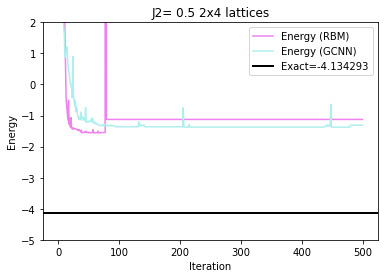

In [23]:
fig, ax1 = plt.subplots()
ax1.plot(iters_RBM1, np.divide(energy_RBM1,float(4.0)), color='violet', label='Energy (RBM)')
ax1.plot(iters_RBM1, np.divide(energy_gcnn,float(4.0)), color='paleturquoise', label='Energy (GCNN)')
# ax1.plot(CQA_iters1, CQA_energy1, color='tomato', label='Energy (Sn-CQA)')

ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax1.set_ylim([-5, 2])
# plt.axis([0,iters_RBM[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=np.divide(exact_gs_energy, float(4.0)), xmin=0,
                xmax=iters_RBM1[-1], linewidth=2, color='k', label='Exact=-4.134293')
ax1.legend()
plt.title('J2= 0.5 2x4 lattices')
plt.show()

## J2 = 0.8 Cases 

In [27]:
J = [1, 0.8]
# graph = nk.graph.Grid(extent= [2,4], pbc=False)
# edges = graph.edges
# nx.draw(graph.to_networkx(), with_labels=True, font_weight='bold')
edge_colors = [[0, 1, 1], [0, 4, 1], [1, 2,1], 
               [2, 3, 1], [2,5,1], [4,6,1], [6,8,1], [6,7,1],
              [5,9,1], [8,9,1],[9,10,1], [9,11,1],
               # J2 terms now for the frustration 
               [1,4,2], [3,5,2], [5,8,2], [7,8,2], [10,11,2], [0,2,2],
               [1,3,2], [2,9,2], [1,5,2], [5,10,2], [5,11,2], [8,10,2],
               [8,11,2], [4,7,2], [0,6,2], [6,9,2], [4,8,2]]

#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))

#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (J[0] * exchange).tolist(),
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]

# graph = nk.graph.Grid(extent= [2,4], pbc=False, edge_colors = edge_colors)
g = nk.graph.Graph(edges=edge_colors)
# nx.draw(g.to_networkx(), with_labels=True, font_weight='bold')
hi = nk.hilbert.Spin(s=float(0.5), total_sz=float(0.0), N=g.n_nodes)
# print(g.edge_colors)
ha = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)
evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
exact_gs_energy2 = evals[0]
print('The exact ground-state energy from computational basis for J2 = {} is-- ({}) '.format(J[1], exact_gs_energy2/float(4))) 



The exact ground-state energy from computational basis for J2 = 0.8 is-- (-4.894586162226811) 


### Using RBM

In [28]:
# RBM ansatz with alpha=1
ma = nk.models.RBM(alpha=1)
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=float(0.05))

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=float(0.1))

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=int(1000))

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBM', n_iter=int(500))
end = time.time()

print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

# import the data from log file
data=json.load(open("RBM.log"))

# Extract the relevant information
iters_RBM2 = data["Energy"]["iters"]
energy_RBM2 = data["Energy"]["Mean"]

100%|██████████| 500/500 [00:14<00:00, 33.46it/s, Energy=-7.000 ± 0.024 [σ²=0.600, R̂=1.4086]]           

### RBM calculation
Has 168 parameters
The RBM calculation took 21.968578100204468 seconds


### Using GCNN

In [30]:
symmetries = g.automorphisms()
#Feature dimensions of hidden layers, from first to last
feature_dims = (8,8,8,8,8,8,8,8)

#Number of layers
num_layers = 8

#Define the GCNN
ma = nk.models.GCNN(symmetries = symmetries, layers = num_layers, features = feature_dims)

#Metropois-Hastings with two spins flipped that are at most second nearest neighbors
sa = nk.sampler.MetropolisExchange(hilbert = hi, graph=g, d_max=2)

#Stochaistic reconfiguration
op = nk.optimizer.Sgd(learning_rate=1e-2)
sr = nk.optimizer.SR(diag_shift=0.01)

#Define a variational state so we can keep the parameters if we like
vstate = nk.variational.MCState(sampler=sa, model=ma, n_samples=200)

#Define a driver that performs VMC
gs = nk.driver.VMC(ha, op, sr=sr, variational_state=vstate)
#Run the optimization
gs.run(n_iter=500, out='out')
#Get data from log and
energy_gcnn2 = []
data_gcnn2=json.load(open("out.log"))
for en in data_gcnn["Energy"]["Mean"]:
    energy_gcnn2.append(en)





100%|██████████| 500/500 [00:35<00:00, 14.12it/s, Energy=-5.530 ± 0.014 [σ²=0.043, R̂=1.3868]]            


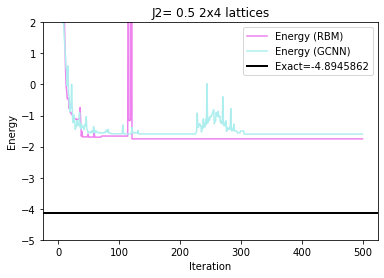

In [32]:
fig, ax1 = plt.subplots()
ax1.plot(iters_RBM2, np.divide(energy_RBM2,float(4.0)), color='violet', label='Energy (RBM)')
ax1.plot(iters_RBM2, np.divide(energy_gcnn2,float(4.0)), color='paleturquoise', label='Energy (GCNN)')
# ax1.plot(CQA_iters1, CQA_energy1, color='tomato', label='Energy (Sn-CQA)')

ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax1.set_ylim([-5, 2])
# plt.axis([0,iters_RBM[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=np.divide(exact_gs_energy, float(4.0)), xmin=0,
                xmax=iters_RBM2[-1], linewidth=2, color='k', label='Exact=-4.8945862')
ax1.legend()
plt.title('J2= 0.5 2x4 lattices')
plt.show()